In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm

import optuna
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_edf,
    plot_slice,
    plot_parallel_coordinate,
)
from optuna.pruners import MedianPruner, SuccessiveHalvingPruner
from optuna import samplers

optuna.logging.set_verbosity(optuna.logging.WARNING)

import tqdm as notebook_tqdm
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')

# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fe = fm.FontEntry(
#     fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',  # ttf 파일이 저장되어 있는 경로
#     name='NanumBarunGothic')  # 이 폰트의 원하는 이름 설정
# fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'})  # 폰트 설정
# plt.rc('font', family='NanumBarunGothic')
fe = fm.FontEntry(
    fname=r'/System/Library/Fonts/Supplemental/AppleGothic.ttf',  # ttf 파일이 저장되어 있는 경로
    name='AppleGothic')  # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'AppleGothic'})  # 폰트 설정
plt.rc('font', family='AppleGothic')

In [2]:
train = pd.read_csv('../03_outlier/train_processed.csv')
test = pd.read_csv('../03_outlier/test_processed.csv')

In [3]:
# is_test 플래그 보장
if 'is_test' not in train.columns:
    train['is_test'] = 0
if 'is_test' not in test.columns:
    test['is_test'] = 1

In [4]:
# 합치기
all_df = pd.concat([train, test], axis=0, ignore_index=True)

In [5]:
target_col = 'target_log_clip'

In [6]:
# 범주형 컬럼 자동 탐지 + (있다면) 명시적 컬럼 포함
auto_cats = train.select_dtypes(include=['object', 'category']).columns.tolist()
explicit_cats = ['연식_bin', '층구간_상대', '브랜드', '아파트명', '도로명', '주소', '구', '동', 'area_bin_in_region']
cat_cols = [c for c in (set(auto_cats) | set(explicit_cats)) if c in train.columns]
num_cols = [c for c in train.columns if c not in cat_cols + [target_col, 'is_test']]

In [7]:
# cat_cols 중 float형만 안전하게 정수형으로 변환(결측 허용 Int64)
for c in cat_cols:
    if pd.api.types.is_float_dtype(all_df[c]):
        try:
            all_df[c] = all_df[c].round().astype('Int64')
        except Exception:
            pass

In [8]:
# 카테고리 정합(합쳐진 데이터에서 category로 변환)
for c in cat_cols:
    all_df[c] = all_df[c].astype('string').fillna('NA').astype('category')

# 다시 train/test 분리
train2 = all_df[all_df['is_test'] == 0].copy()
test2 = all_df[all_df['is_test'] == 1].copy()

In [9]:
# 피처/타깃 분리
drop_cols = [target_col, 'is_test'] if target_col in train2.columns else ['is_test']
X = train2.drop(columns=[c for c in drop_cols if c in train2.columns]).copy()
y = train2[target_col].astype(float).copy()
X_test = test2.drop(columns=['is_test']).copy()

print(f"[INFO] cat_cols 내 float→Int64 변환 및 카테고리 정합 완료")
print(f"[INFO] OHE 대상(cat_cols) 컬럼 수: {len(cat_cols)}")
print(f"[INFO] X.shape={X.shape}, X_test.shape={X_test.shape}")

[INFO] cat_cols 내 float→Int64 변환 및 카테고리 정합 완료
[INFO] OHE 대상(cat_cols) 컬럼 수: 23
[INFO] X.shape=(107534, 67), X_test.shape=(9272, 68)


In [10]:
# One-Hot + 패스스루 전처리 빌더
def make_preprocessor():
    # 모든 cat_cols가 문자열로 통일되어 있으므로 타입 혼합 오류가 사라집니다.
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
    pre = ColumnTransformer(
        transformers=[('cat', ohe, cat_cols)],
        remainder='passthrough',  # 수치형은 그대로 통과
        sparse_threshold=0.0
    )
    return pre


In [25]:
# KFold 인덱스 캐싱(모든 트라이얼에서 재사용)
_kf = KFold(n_splits=5, shuffle=True, random_state=2023)
_fold_indices = list(_kf.split(X, y))

In [26]:
# Optuna 병렬 수에 따른 내부 모델 n_jobs 제어용 플래그
OPTUNA_PARALLEL_JOBS = max(1, (os.cpu_count() or 2) // 2)
print(f"[INFO] Optuna parallel jobs = {OPTUNA_PARALLEL_JOBS}")

[INFO] Optuna parallel jobs = 5


In [27]:
def objective(trial: optuna.trial.Trial) -> float:
    # 하이퍼파라미터 범위 축소로 탐색 효율 향상
    max_features_choice = trial.suggest_categorical('max_features_mode', ['sqrt', 'log2', 'float'])
    if max_features_choice == 'float':
        max_features = trial.suggest_float('max_features', 0.3, 1.0)
    else:
        max_features = max_features_choice

    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    n_estimators = trial.suggest_int('n_estimators', 400, 1200)  # 상한 축소(속도↑, 과적합↓)
    params = {
        'n_estimators': n_estimators,
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': max_features,
        'bootstrap': bootstrap,
        'criterion': 'squared_error',
        'random_state': 2023,
        # 중첩 병렬화 방지: Optuna가 병렬일 땐 트리 학습은 단일 스레드
        'n_jobs': 1 if OPTUNA_PARALLEL_JOBS > 1 else -1,
        # warm_start는 진행바 목적일 때만 유용하므로 여기선 생략(순수 속도 우선)
    }
    if bootstrap:
        params['max_samples'] = trial.suggest_float('max_samples', 0.6, 1.0)

    # 초기 몇 개 트라이얼은 데이터 샘플링으로 아주 빠르게 거르기
    # 예: 전체의 60%만 사용(성능 괜찮으면 이후 전체 데이터로 수렴)
    subsample_frac = 0.6 if trial.number < 10 else 1.0
    if subsample_frac < 1.0:
        rng = np.random.default_rng(2023 + trial.number)
        idx = rng.choice(len(X), size=int(len(X) * subsample_frac), replace=False)
        X_use = X.iloc[idx]
        y_use = y.iloc[idx]
        fold_indices = list(KFold(n_splits=5, shuffle=True, random_state=2023).split(X_use, y_use))
    else:
        X_use, y_use, fold_indices = X, y, _fold_indices

    rmses = []
    for step, (trn_idx, val_idx) in enumerate(fold_indices, start=1):
        X_trn, X_val = X_use.iloc[trn_idx], X_use.iloc[val_idx]
        y_trn, y_val = y_use.iloc[trn_idx], y_use.iloc[val_idx]

        pre = make_preprocessor()
        model = RandomForestRegressor(**params)
        pipe = Pipeline(steps=[('pre', pre), ('model', model)])

        pipe.fit(X_trn, y_trn)
        val_pred_log = pipe.predict(X_val)
        rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
        rmses.append(rmse)

        # 프루닝을 위한 중간 보고
        trial.report(float(rmse), step=step)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(rmses))


In [28]:
# Optuna Study: 고도화된 Sampler/Pruner + 개선 없을 때 중단
sampler = samplers.TPESampler(
    seed=2023,
    n_startup_trials=10,  # 초기 탐색(너무 크면 느림)
    multivariate=True,
    group=True
)
# 빠르고 공격적인 프루닝: 중앙값 + SH 조합 중 택1
# 보수적이면 MedianPruner, 더 공격적이면 SuccessiveHalvingPruner
pruner = MedianPruner(n_startup_trials=10, n_warmup_steps=0)

study = optuna.create_study(
    direction='minimize',
    study_name='rf_kfold_opt_ohe',
    sampler=sampler,
    pruner=pruner
)


# 개선 없을 때 조기 종료 콜백
class StopIfNoImprovement:
    def __init__(self, patience=15):
        self.patience = patience
        self.best = np.inf
        self.count = 0

    def __call__(self, study_, trial_):
        if study_.best_value < self.best - 1e-8:
            self.best = study_.best_value
            self.count = 0
        else:
            self.count += 1
        if self.count >= self.patience:
            print(f"[Optuna] No improvement in {self.patience} trials. Stopping...")
            study_.stop()


n_trials = 40
trials_pbar = tqdm(total=n_trials, desc="Optuna Trials")


def _tqdm_callback(study_, trial_):
    trials_pbar.update(1)
    try:
        trials_pbar.set_postfix(best=f"{study_.best_value:.4f}")
    except Exception:
        pass


study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=OPTUNA_PARALLEL_JOBS,  # 병렬 트라이얼
    show_progress_bar=False,
    callbacks=[_tqdm_callback, StopIfNoImprovement(patience=12)]
)
trials_pbar.close()

print("[OPTUNA] Best value (mean RMSE):", study.best_value)
print("[OPTUNA] Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")


Optuna Trials:   0%|          | 0/1 [00:00<?, ?it/s]

[OPTUNA] Best value (mean RMSE): 45382.16830649368
[OPTUNA] Best params:
  - max_features_mode: log2
  - bootstrap: True
  - n_estimators: 829
  - max_depth: 15
  - min_samples_split: 15
  - min_samples_leaf: 4
  - max_samples: 0.7866957522404484


In [11]:
best_params = study.best_params.copy()

# max_features 처리
if best_params.get('max_features_mode') == 'float':
    max_features = best_params['max_features']
else:
    max_features = best_params['max_features_mode']
best_params.pop('max_features_mode', None)
best_params['max_features'] = max_features

# RandomForest 고정 파라미터
best_params.update({
    'n_jobs': -1,
    'random_state': 2023,
    'criterion': 'squared_error',
})

print("[PARAMS] 최종 사용 파라미터:", best_params)

NameError: name 'study' is not defined

In [19]:
# K-Fold OOF 평가 (파이프라인 사용)
kf = KFold(n_splits=5, shuffle=True, random_state=2023)
oof_pred_log = np.zeros(len(X))
fold_rmses = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y), start=1):
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    pre = make_preprocessor()
    model = RandomForestRegressor(**best_params)
    pipe = Pipeline(steps=[('pre', pre), ('model', model)])

    pipe.fit(X_trn, y_trn)
    val_pred_log = pipe.predict(X_val)
    oof_pred_log[val_idx] = val_pred_log

    rmse = np.sqrt(mean_squared_error(np.expm1(y_val.values), np.expm1(val_pred_log)))
    fold_rmses.append(rmse)
    print(f"[KFold] Fold {fold} RMSE(orig) = {rmse:,.5f}")

print(f"[KFold] CV RMSE(orig): mean={np.mean(fold_rmses):,.5f}, std={np.std(fold_rmses):,.5f}")

[KFold] Fold 1 RMSE(orig) = 45,522.30638
[KFold] Fold 2 RMSE(orig) = 45,508.37132
[KFold] Fold 3 RMSE(orig) = 44,871.61104
[KFold] Fold 4 RMSE(orig) = 44,941.18015
[KFold] Fold 5 RMSE(orig) = 46,433.97846
[KFold] CV RMSE(orig): mean=45,455.48947, std=560.38019


In [20]:
# 전체 데이터로 재학습 후 테스트 예측
final_pre = make_preprocessor()
final_model = RandomForestRegressor(**best_params)
final_pipe = Pipeline(steps=[('pre', final_pre), ('model', final_model)])
final_pipe.fit(X, y)

,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
# 학습데이터 예측 (로그스케일 -> 원스케일)
preds_train_log = final_pipe.predict(X)
y_true = np.expm1(y.values)
y_pred = np.expm1(preds_train_log)

[Train In-sample] RMSE(orig) = 45,479.9319
[Train In-sample] MAE(orig)  = 27,231.5638
[Train In-sample] R²         = 0.0318


,y_true,y_pred,residual
0,124000.0,57327.025144,66672.974856
1,123500.0,57355.615209,66144.384791
2,91500.0,56939.999467,34560.000533
3,130000.0,57378.470034,72621.529966
4,117000.0,57349.868577,59650.131423
5,130000.0,57368.036190,72631.963810
6,139500.0,57260.969399,82239.030601
7,107500.0,56748.302328,50751.697672
8,145000.0,57267.033505,87732.966495
9,112000.0,56833.526587,55166.473413


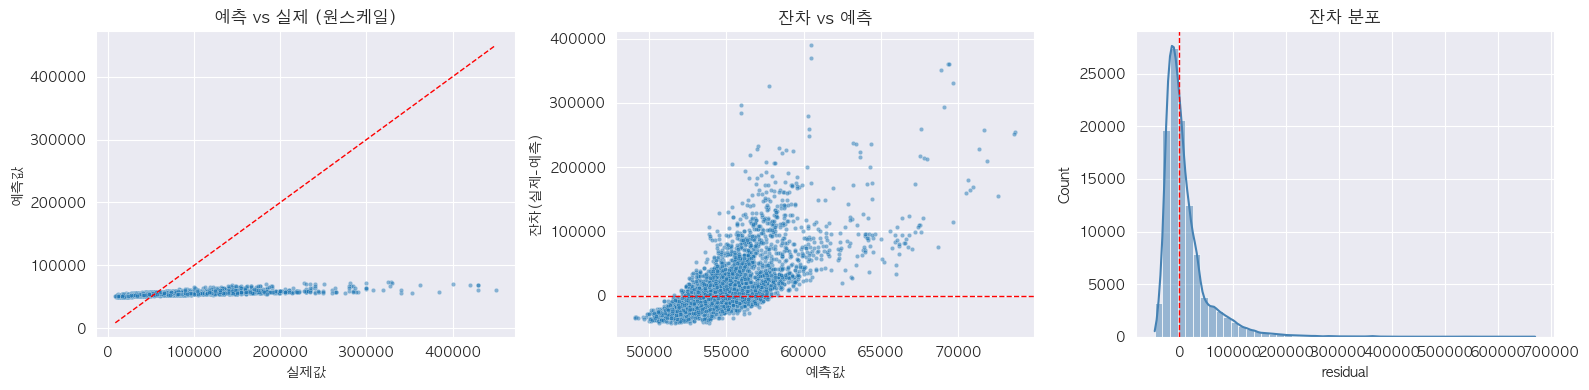

In [23]:
# 안전장치(음수 방지), 반올림 버전이 필요하면 아래 주석 해제
y_pred = np.maximum(0, y_pred)
# y_pred_int = y_pred.round().astype(np.int64)

# 지표 계산
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)

print(f"[Train In-sample] RMSE(orig) = {rmse:,.4f}")
print(f"[Train In-sample] MAE(orig)  = {mae:,.4f}")
print(f"[Train In-sample] R²         = {r2:,.4f}")

# 비교/잔차 프레임
compare_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
})
compare_df['residual'] = compare_df['y_true'] - compare_df['y_pred']
display(compare_df.head(10))

# 필요 시 저장
# compare_df.to_csv('rf_train_vs_pred.csv', index=False)

# 시각화(샘플 5,000개까지)
sample = compare_df.sample(min(5000, len(compare_df)), random_state=2023)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1) 예측 vs 실제
sns.scatterplot(x='y_true', y='y_pred', data=sample, s=10, alpha=0.5, ax=axes[0])
lim_min = min(sample['y_true'].min(), sample['y_pred'].min())
lim_max = max(sample['y_true'].max(), sample['y_pred'].max())
axes[0].plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', linewidth=1)
axes[0].set_title('예측 vs 실제 (원스케일)')
axes[0].set_xlabel('실제값')
axes[0].set_ylabel('예측값')

# 2) 잔차 vs 예측
sns.scatterplot(x='y_pred', y='residual', data=sample, s=10, alpha=0.5, ax=axes[1])
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1].set_title('잔차 vs 예측')
axes[1].set_xlabel('예측값')
axes[1].set_ylabel('잔차(실제-예측)')

# 3) 잔차 분포
sns.histplot(compare_df['residual'], bins=50, kde=True, ax=axes[2], color='steelblue')
axes[2].axvline(0, color='red', linestyle='--', linewidth=1)
axes[2].set_title('잔차 분포')

plt.tight_layout()
plt.show()


In [ ]:
preds_test_log = final_pipe.predict(X_test)
preds_test = np.expm1(preds_test_log)
preds_test = np.maximum(0, preds_test)  # 음수 방지 안전장치
preds_test_int = preds_test.round().astype(np.int64)

In [32]:
# 저장
sub_path = 'rf_optuna_kfold_ohe.csv'
pd.DataFrame({'target': preds_test_int}).to_csv(sub_path, index=False)
print(f"[SAVE] {sub_path} 저장 완료")


[SAVE] rf_optuna_kfold_ohe.csv 저장 완료


In [33]:
# 파이프라인에서 전처리와 모델 추출
pre_fitted = final_pipe.named_steps['pre']
rf_fitted = final_pipe.named_steps['model']

In [34]:
# 확장된 피처 이름
feature_names = pre_fitted.get_feature_names_out()
importances = pd.Series(rf_fitted.feature_importances_, index=feature_names).sort_values(ascending=False)

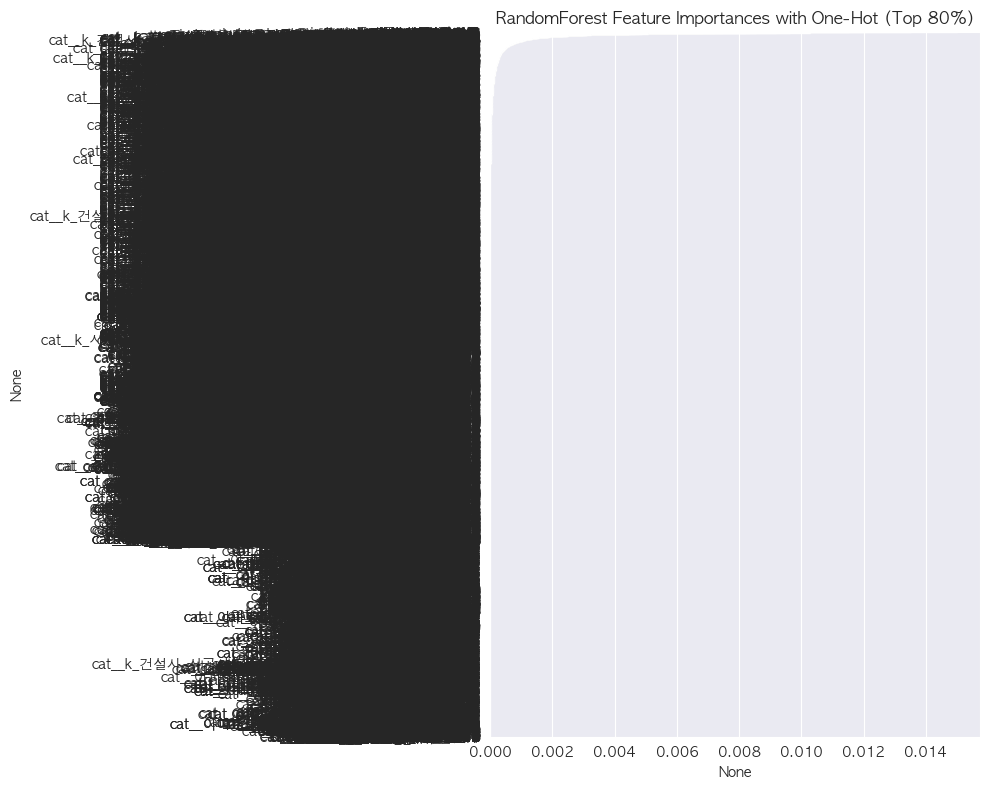

In [35]:
# 상위 80%만 시각화
top_n = max(1, int(np.ceil(len(importances) * 0.8)))
imp_top = importances.iloc[:top_n]

plt.figure(figsize=(10, 8))
plt.title("RandomForest Feature Importances with One-Hot (Top 80%)")
sns.barplot(x=imp_top, y=imp_top.index, color='steelblue')
plt.tight_layout()
plt.show()